In [1]:
################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2024-05-15
## Last Edited: 2024-05-24
################################################################################

In [519]:
## Load libraries
################################################################################
import os
import pandas as pd
import numpy as np
import random
from scipy import integrate
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

In [520]:
## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/in_vitro_CLIP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    if (MAX <= MIN):
        raise ValueError("MAX cannot be lower than or equal to MIN.")
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def processFASTA(PATH, NAME):
    ID = ''
    SEQ = ''
    
    # Read the FASTA file
    with open(os.path.expanduser(PATH + 'target_RNA/' + NAME + '.fa'), 'r') as f:
        for line in f:
            if line.startswith('>'):
                # Extract chromosome number and calculate length
                header_info = line.split(' ')[1]  # Get the first part of the header
                ID = header_info.split('=')[1].split(':')[0]  # Extract chromosome number
                start, end = map(int, header_info.split('=')[1].split(':')[1].split('-'))  # Extract start and end positions
            else:
                SEQ += line.strip()  # Add sequence
    
    LEN = len(SEQ)

    # Return the processed information
    return [ID, LEN, NAME, SEQ.replace('T', 'U')]

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq


In [521]:
## Process RNACompete Data
################################################################################
RNCMPT_org = pd.read_table(baseDir + 'RNACompete/z_scores.txt')
RBP_List = pd.read_table(baseDir + 'RNACompete/rbp_list.txt')

RNCMPT = RNCMPT_org[['7mer'] + [col for col in RNCMPT_org.columns if col.endswith('_setAB')]]
RNCMPT.columns = ['Motif'] + [col.replace('_z_setAB', '') for col in RNCMPT.columns[1:]]
RNCMPT = RNCMPT[['Motif'] + list(RBP_List.RNACompete)]

RNCMPT_norm = RNCMPT.copy()
RNCMPT_norm.iloc[:, 1:] = RNCMPT_norm.iloc[:, 1:].apply(lambda x: featureScale(x, 1, 0))

# RNCMPT_norm.to_csv(baseDir + 'RNACompete/normed_7mer.csv')

RNCMPT_norm['PTBP1'] = RNCMPT_norm[RBP_List[RBP_List.RBP == 'PTBP1'].RNACompete].mean(axis = 1)
RNCMPT_norm = RNCMPT_norm.drop(columns = RBP_List[RBP_List.RBP == 'PTBP1'].RNACompete)

RNCMPT_norm['HuR'] = RNCMPT_norm[RBP_List[RBP_List.RBP == 'HuR'].RNACompete].mean(axis = 1)
RNCMPT_norm = RNCMPT_norm.drop(columns = RBP_List[RBP_List.RBP == 'HuR'].RNACompete)

RNCMPT_norm.columns = ['Motif', 'U2AF2', 'HNRNPC', 'MBNL1', 'RBM24', 'RBM41', 'SNRPA', 'KHDRBS1', 'PCBP1', 'PTBP1', 'HuR']

RBP_IS = pd.DataFrame({
    'RBP': (1/RNCMPT_norm.iloc[:, 1:11].median()).index,
    'IS': (1/RNCMPT_norm.iloc[:, 1:11].median()).values
})


RNCMPT['PTBP1'] = RNCMPT[RBP_List[RBP_List.RBP == 'PTBP1'].RNACompete].mean(axis = 1)
RNCMPT = RNCMPT.drop(columns = RBP_List[RBP_List.RBP == 'PTBP1'].RNACompete)

RNCMPT['HuR'] = RNCMPT[RBP_List[RBP_List.RBP == 'HuR'].RNACompete].mean(axis = 1)
RNCMPT = RNCMPT.drop(columns = RBP_List[RBP_List.RBP == 'HuR'].RNACompete)

RNCMPT.columns = ['Motif', 'U2AF2', 'HNRNPC', 'MBNL1', 'RBM24', 'RBM41', 'SNRPA', 'KHDRBS1', 'PCBP1', 'PTBP1', 'HuR']

In [522]:
RBP_IS

,RBP,IS
0,U2AF2,27.02365
1,HNRNPC,26.91209
2,MBNL1,10.59353
3,RBM24,17.59611
4,RBM41,10.74817
5,SNRPA,14.07377
6,KHDRBS1,11.89856
7,PCBP1,5.69726
8,PTBP1,7.52061
9,HuR,14.82683


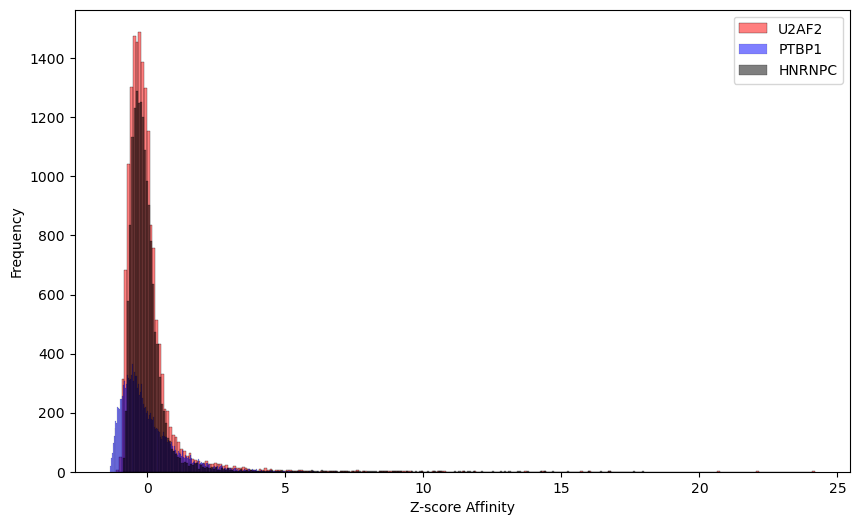

In [523]:
## Visualize normalized affinity distributions
################################################################################
plt.figure(figsize = (10, 6))
sns.histplot(RNCMPT.U2AF2, kde = False, color = 'red', alpha = 0.5, label = 'U2AF2', bins = 250)
sns.histplot(RNCMPT.PTBP1, kde = False, color = 'blue', alpha = 0.5, label = 'PTBP1', bins = 250)
sns.histplot(RNCMPT.HNRNPC, kde = False, color = 'black', alpha = 0.5, label = 'HNRNPC', bins = 250)
plt.xlabel('Z-score Affinity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

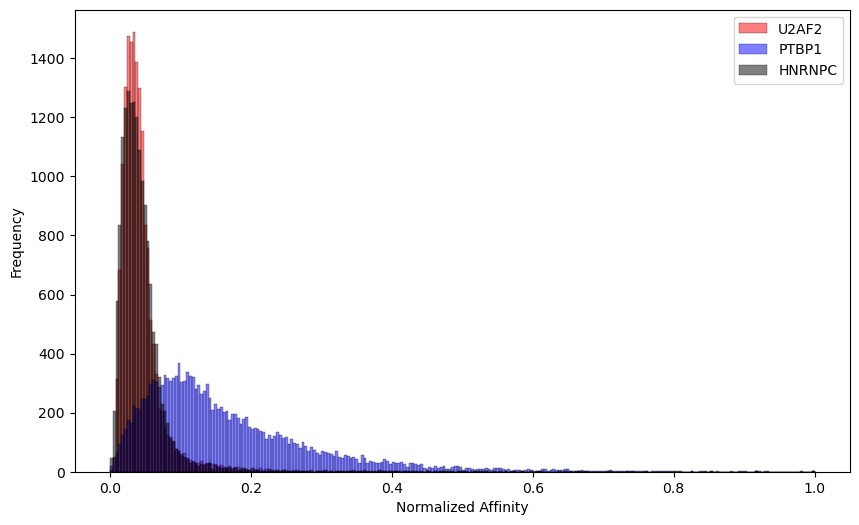

In [524]:
## Visualize normalized affinity distributions
################################################################################
plt.figure(figsize = (10, 6))
sns.histplot(RNCMPT_norm.U2AF2, kde = False, color = 'red', alpha = 0.5, label = 'U2AF2', bins = 250)
sns.histplot(RNCMPT_norm.PTBP1, kde = False, color = 'blue', alpha = 0.5, label = 'PTBP1', bins = 250)
sns.histplot(RNCMPT_norm.HNRNPC, kde = False, color = 'black', alpha = 0.5, label = 'HNRNPC', bins = 250)
plt.xlabel('Normalized Affinity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [525]:
## Process Target RNA Data
################################################################################
RNA_List = ['PTBP2', 'MAT2A', 'MIRLET7A2', 'MALAT1', 'CD55', 'PCBP2', 'NF1', 'PAPD4', 'C4BPB', 'MYL6', 'MYC', 'NUP133']
RNA_Targets = pd.DataFrame(map(lambda name: processFASTA(baseDir, name), RNA_List), columns=['chr', 'length', 'name', 'sequence'])


In [526]:
## Set up query RNA:
################################################################################
# query:          RNA sequence to test.
# L:              length of the query sequence.
# K:              K-mer
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.

K = 7

RNA_Target = 'PTBP2'
# query = RNA_Targets[RNA_Targets.name == RNA_Target].sequence.values[0]
# L = RNA_Targets[RNA_Targets.name == RNA_Target].length.values[0]

# query = 'TCATCCATAACGAAGGGTGGTTCCCGCAGAATGGTGAGGTGGTCATGGATCATGGTTCAAGGCGGTTAATTGGGGCAAGTTGGTCCGAGGAACATTTGTTCAAGCACAGAAGCATGAACATAGGGAATGGAGACAGGGAATGAAGACAAGGACAAGGAAAATAAAGGATAAGACAGGGAAGGGAATGGGCATTTGGGAAAAGACAAGGAAAGGGAAGGTGAACACACAGGGAAAAGGATGAAATGGGGAAGGGAAACAGCAATGCAGAAGAAAAAAATAAGGAATTGGGGAACAAAAACAAAATAAAATATAGGTCAGTACATAGGAAATGCAGGAATTTGGTCAGAAAATGGTTGGTTTATGTACTGTACAAGAAAAACTGAGTAAAATGTAGTCATCCA'
# query = query[201:400]
query = 'GTACTGACCTATATTTTATTTTGTTTTTGTTCCCCAATTCCTTATTTTTT TCTTCTGCATTGCTGTTTCCCTTCCCCATTTCATCCTTTTCCCTGTGTGT TCACCTTCCCTTTCCTTGTCTTTTCCCAAATGCCCATTCCCTTCCCTGTC TTATCCTTTATTTTCCTTGTCCTTGTCTTCATTCCCTGTCTCCATTCCCT A'
query = query.replace('T', 'U').replace(' ', '')
L = len(query)

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))


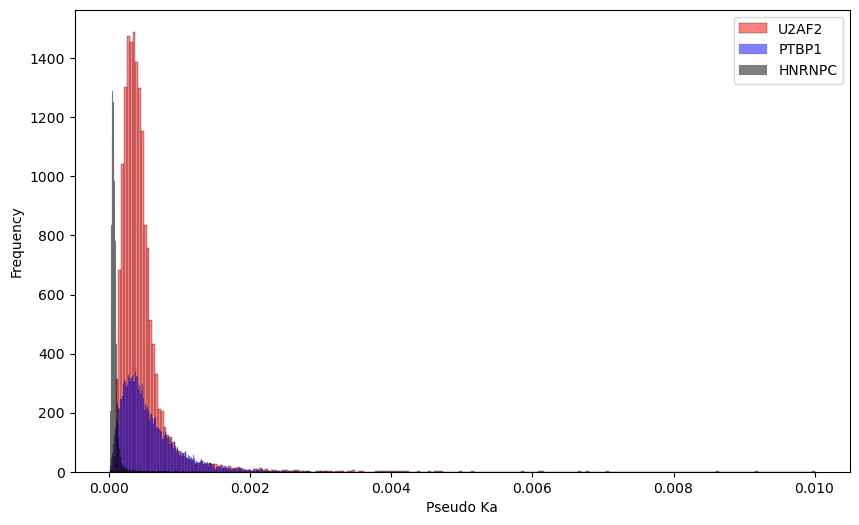

In [551]:
## Set up RBP:
################################################################################
## Used for Figures
U2AF2_KaH = 1/100
U2AF2_KaL = 0.00001
PTBP1_KaH = 1/300
PTBP1_KaL = 0.00001
HNRNPC_KaH = 1/700
HNRNPC_KaL = 0.00001
##

# U2AF2_KaH = 1/100
# U2AF2_KaL = 0.0001
# PTBP1_KaH = 1/300
# PTBP1_KaL = 0.00001
# HNRNPC_KaH = 1/100
# HNRNPC_KaL = 0.0001

# U2AF2_KaH = 300
# U2AF2_KaL = 0

# PTBP1_KaH = 200
# PTBP1_KaL = 0

# HNRNPC_KaH = 200
# HNRNPC_KaL = 50


RBP_Ka = pd.DataFrame({
    'Motif': RNCMPT_norm.Motif,
    'U2AF2': RNCMPT_norm.U2AF2,
    'PTBP1': RNCMPT_norm.PTBP1,
    'HNRNPC': RNCMPT_norm.HNRNPC
})
RBP_Ka.U2AF2 = featureScale(RBP_Ka.U2AF2, MAX=U2AF2_KaH, MIN=U2AF2_KaL)
RBP_Ka.PTBP1 = featureScale(RBP_Ka.PTBP1, MAX=PTBP1_KaH, MIN=PTBP1_KaL)
RBP_Ka.HNRNPC = featureScale(RBP_Ka.HNRNPC, MAX=HNRNPC_KaH, MIN=HNRNPC_KaL)

## Visualize affinity distributions for the selected RBPs
################################################################################
plt.figure(figsize = (10, 6))
sns.histplot(RBP_Ka.U2AF2, kde = False, color = 'red', alpha = 0.5, label = 'U2AF2', bins = 250)
sns.histplot(RBP_Ka.PTBP1, kde = False, color = 'blue', alpha = 0.5, label = 'PTBP1', bins = 250)
sns.histplot(RBP_Ka.HNRNPC, kde = False, color = 'black', alpha = 0.5, label = 'HNRNPC', bins = 250)
plt.xlabel('Pseudo Ka')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [552]:
## Set up simulation for U2AF2:
################################################################################
N = 1
U2AF20 = 500

P0 = [U2AF20]
R0 = 10

In [553]:
## Run simulation for U2AF2:
################################################################################
U2AF2 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.U2AF2,
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'U2AF2Req': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_U2AF2 = U2AF2.loc[U2AF2.motif == window, 'Kd'].values[0]

  Kd = [Kd_U2AF2]
  Req = allBind(N, eR0, P0, Kd)
  
  U2AF2Req = (U2AF20 * Req)/(Kd_U2AF2 + Req)
 
  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'U2AF2Req'] = U2AF2Req/appearance

simulation = simulation.sort_values(by = ["win_num"])

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'U2AF2Req': np.zeros(L),
    'U2AF2/U2AF20': np.zeros(L)
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] = simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] + simulation.U2AF2Req[idx]

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['U2AF2Req'] = simulation_per_pos['U2AF2Req'] / np.maximum(update_counts, 1)


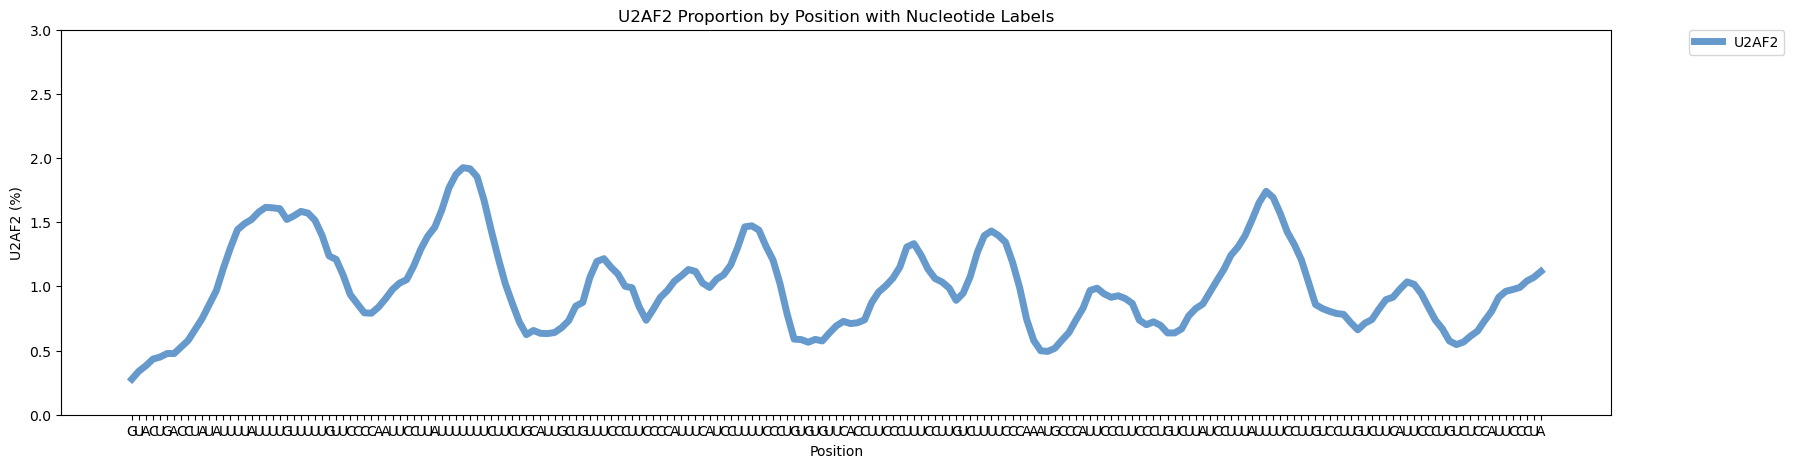

In [554]:
## Plot per position values for U2AF2:

plot_data_U2AF2 = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'U2AF2Req': simulation_per_pos.U2AF2Req/R0/sum(simulation_per_pos.U2AF2Req/R0)*U2AF20,
    # 'U2AF2Req': simulation_per_pos.U2AF2Req/R0/sum(simulation_per_pos.U2AF2Req/R0)*100,
    # 'U2AF2Req': simulation_per_pos.U2AF2Req/trapz(simulation_per_pos.U2AF2Req, simulation_per_pos.pos)*100,
    'U2AF2Req': (U2AF20*simulation_per_pos.U2AF2Req/integrate.trapezoid(simulation_per_pos.U2AF2Req,simulation_per_pos.pos))/ (U2AF20/len(query)),
    # 'U2AF2Req': (U2AF20*simulation_per_pos.U2AF2Req/integrate.trapezoid(simulation_per_pos.U2AF2Req,simulation_per_pos.pos))
})

plot_data_U2AF2 = plot_data_U2AF2.melt(id_vars='pos', value_vars=['U2AF2Req'], var_name='variable', value_name='value')

# plot_data_U2AF2.value = (plot_data_U2AF2.value)/trapz(plot_data_U2AF2.value, plot_data_U2AF2.pos)
# plot_data_U2AF2.value = (plot_data_U2AF2.value)/sum(plot_data_U2AF2.value)


plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data_U2AF2, x='pos', y='value', color = '#6699CC', label = 'U2AF2', lw = 5)

plt.ylim(0.0, 3)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('U2AF2 (%)')
plt.title('U2AF2 Proportion by Position with Nucleotide Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

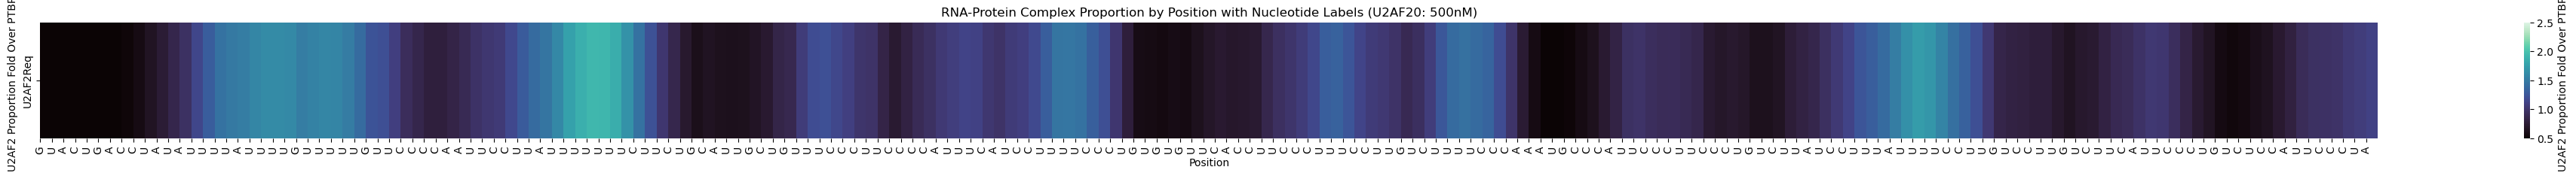

In [555]:
## Heatmap

plot_data_U2AF2 = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'U2AF2Req': (U2AF20*simulation_per_pos.U2AF2Req/integrate.trapezoid(simulation_per_pos.U2AF2Req,simulation_per_pos.pos)) / (U2AF20/len(query)),
})

plot_data_U2AF2 = plot_data_U2AF2.melt(id_vars='pos', value_vars=['U2AF2Req'], var_name='variable', value_name='value')

heatmap_data = plot_data_U2AF2.pivot(index='pos', columns='variable', values='value')

# Create the heatmap
plt.figure(figsize=(50, 2))
sns.heatmap(heatmap_data.T, cmap='mako', cbar_kws={'label': 'U2AF2 Proportion Fold Over PTBP1'}, vmin=0.5, vmax=2.5)

plt.xlabel('Position')
plt.ylabel('U2AF2 Proportion Fold Over PTBP1')
plt.title('RNA-Protein Complex Proportion by Position with Nucleotide Labels (U2AF20: ' + str(U2AF20) + 'nM)')
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

# plt.show()
plt.savefig('/Users/soonyi/Desktop/U2AF2.pdf')

In [537]:
## Set up simulation for PTBP1:
################################################################################
N = 1
PTBP10 = 500

P0 = [PTBP10]
R0 = 10

In [538]:
## Run simulation for PTBP1:
################################################################################

PTBP1 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.PTBP1,
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'PTBP1Req': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_PTBP1 = PTBP1.loc[PTBP1.motif == window, 'Kd'].values[0]

  Kd = [Kd_PTBP1]
  Req = allBind(N, eR0, P0, Kd)
  
  PTBP1Req = (PTBP10 * Req)/(Kd_PTBP1 + Req)
 
  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'PTBP1Req'] = PTBP1Req/appearance

simulation = simulation.sort_values(by = ["win_num"])

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'PTBP1Req': np.zeros(L),
    'PTBP1/PTBP10': np.zeros(L)
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'PTBP1Req'] = simulation_per_pos.loc[idx:idx+K-1, 'PTBP1Req'] + simulation.PTBP1Req[idx]

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['PTBP1Req'] = simulation_per_pos['PTBP1Req'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['PTBP1/R0'] = (simulation_per_pos['PTBP1Req'])/R0


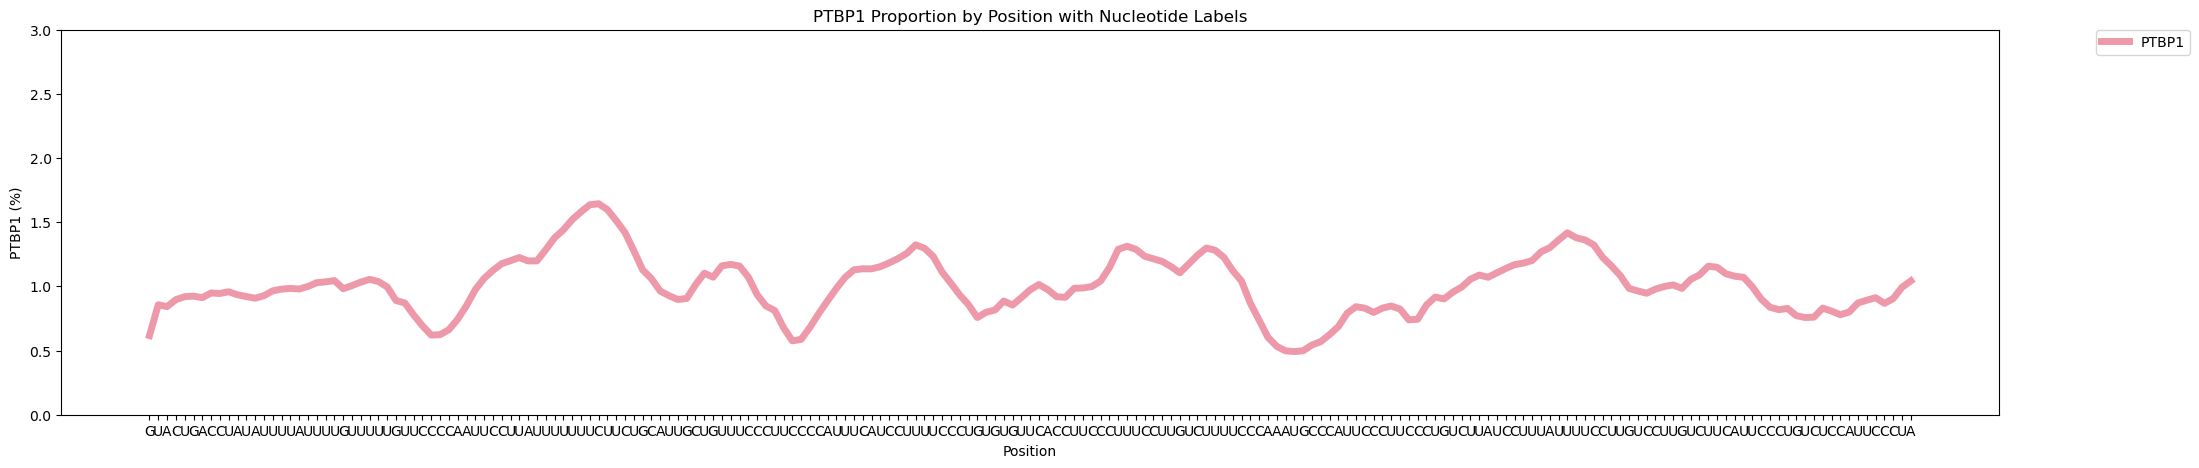

In [539]:
## Plot per position values for PTBP1:

plot_data_PTBP1 = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'PTBP1Req': simulation_per_pos.PTBP1Req/R0/sum(simulation_per_pos.PTBP1Req/R0)*100,
    # 'PTBP1Req': simulation_per_pos.PTBP1Req/R0/sum(simulation_per_pos.PTBP1Req/R0)*PTBP10,
    'PTBP1Req': (PTBP10*simulation_per_pos.PTBP1Req/integrate.trapezoid(simulation_per_pos.PTBP1Req,simulation_per_pos.pos))/ (PTBP10/len(query))
})

plot_data_PTBP1 = plot_data_PTBP1.melt(id_vars='pos', value_vars=['PTBP1Req'], var_name='variable', value_name='value')

# plot_data_PTBP1.value = (plot_data_PTBP1.value)/trapz(plot_data_PTBP1.value, plot_data_PTBP1.pos)
# plot_data_PTBP1.value = (plot_data_PTBP1.value)/sum(plot_data_PTBP1.value)

plt.figure(figsize=(25, 5))
sns.lineplot(data=plot_data_PTBP1, x='pos', y='value', color = '#EE99AA', label = 'PTBP1', lw = 5)

plt.ylim(0.0, 3)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('PTBP1 (%)')
plt.title('PTBP1 Proportion by Position with Nucleotide Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


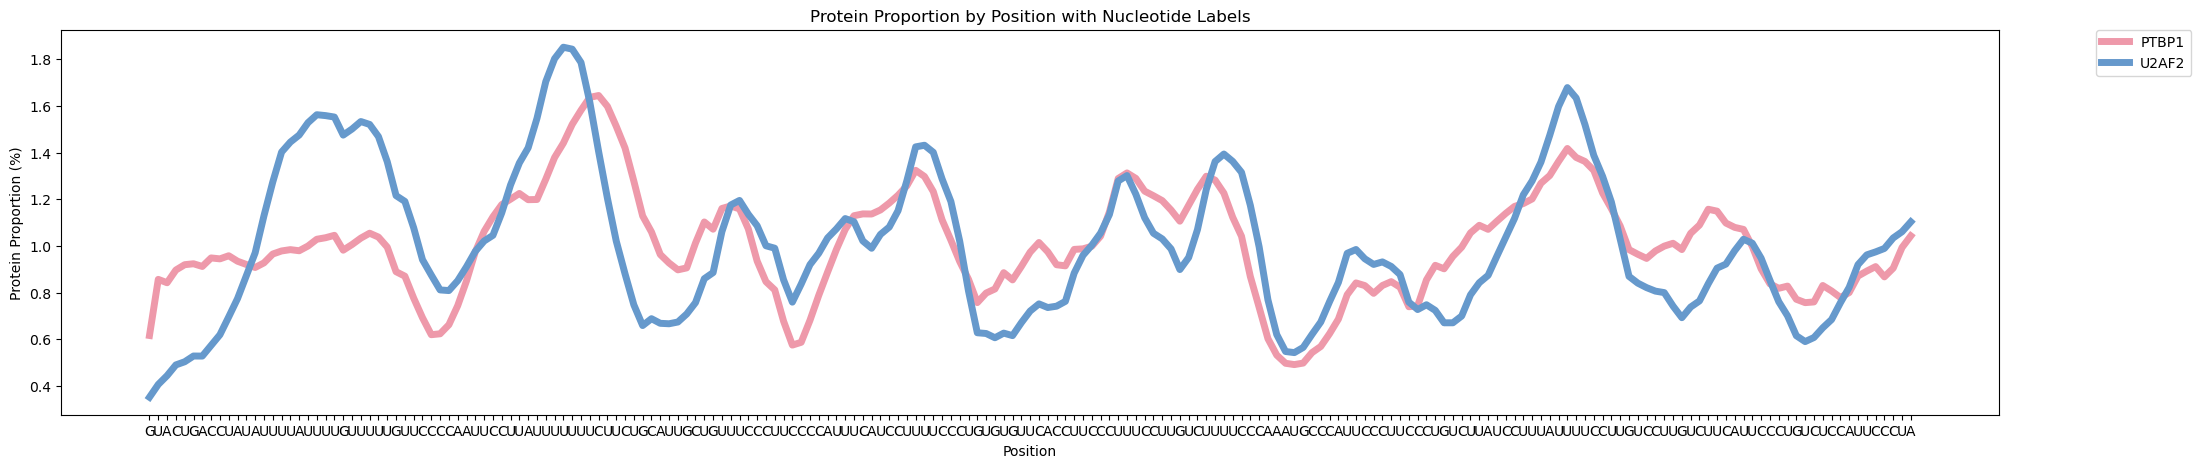

In [540]:
## Single RBP Plots Overlap

plt.figure(figsize=(25, 5))
sns.lineplot(data=plot_data_PTBP1, x='pos', y='value', color = '#EE99AA', label = 'PTBP1', lw = 5)
sns.lineplot(data=plot_data_U2AF2, x='pos', y='value', color = '#6699CC', label = 'U2AF2', lw = 5)

# plt.ylim(0.98, 1.015)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Protein Proportion (%)')
plt.title('Protein Proportion by Position with Nucleotide Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


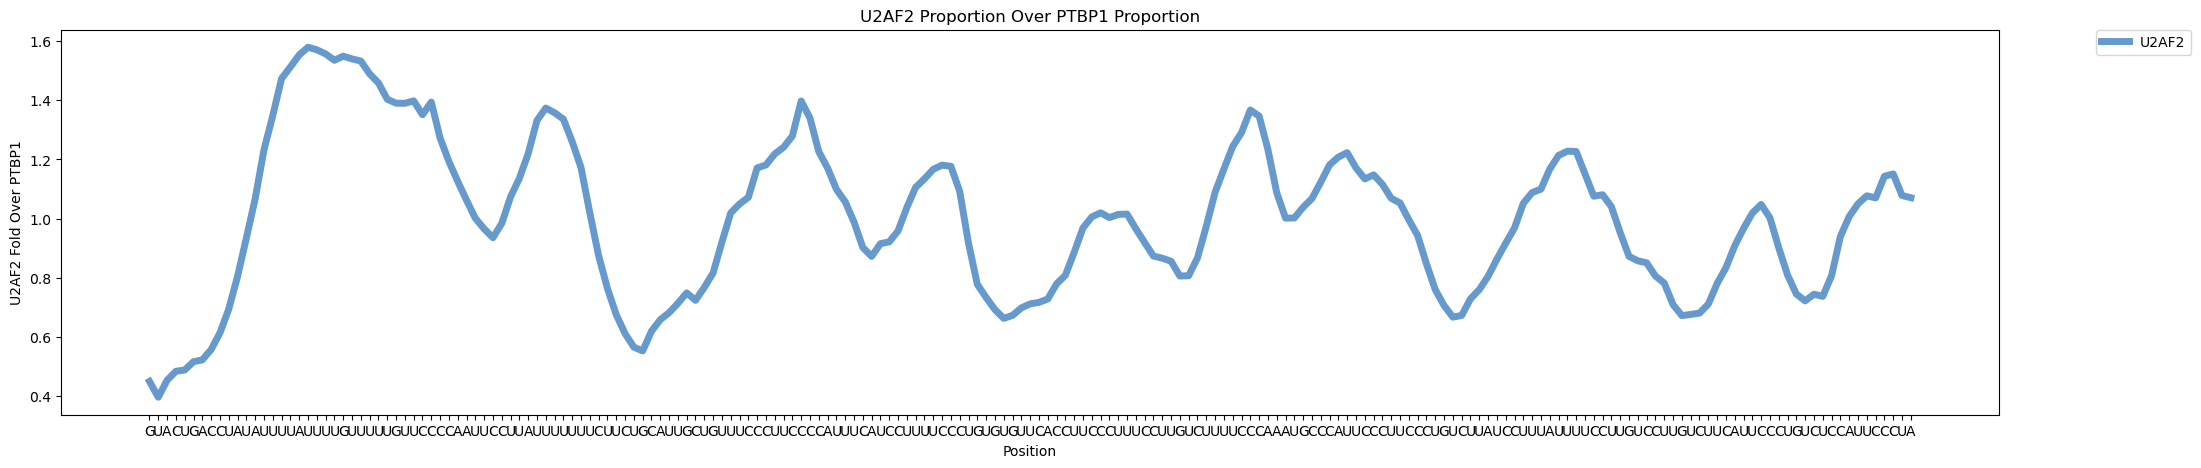

In [273]:
## U2AF2 proportion over PTBP1 proportion

plot_data_combined = pd.DataFrame({
    'pos': plot_data_U2AF2.pos,
    'variable': plot_data_U2AF2.variable,
    'value': plot_data_U2AF2.value / plot_data_PTBP1.value
})

plt.figure(figsize=(25, 5))
sns.lineplot(data=plot_data_combined, x='pos', y='value', color = '#6699CC', label = 'U2AF2', lw = 5)

# plt.ylim(0.0, 0.1)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('U2AF2 Fold Over PTBP1')
plt.title('U2AF2 Proportion Over PTBP1 Proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [556]:
## Set up simulation for U2AF2 and PTBP1:
################################################################################
N = 2
U2AF20 = 500
PTBP10 = 200

P0 = [U2AF20, PTBP10]
R0 = 10

In [557]:
## Run simulation for U2AF2 and PTBP1:
################################################################################
U2AF2 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.U2AF2,
   })


PTBP1 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.PTBP1,
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'U2AF2Req': [None] * W,
   'PTBP1Req': [None] * W
   })


## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  
  Kd_U2AF2 = U2AF2.loc[U2AF2.motif == window, 'Kd'].values[0]
  Kd_PTBP1 = PTBP1.loc[PTBP1.motif == window, 'Kd'].values[0]

  Kd = [Kd_U2AF2, Kd_PTBP1]
  Req = allBind(N, eR0, P0, Kd)
  
  U2AF2Req = (U2AF20 * Req)/(Kd_U2AF2 + Req)
  PTBP1Req = (PTBP10 * Req)/(Kd_PTBP1 + Req)
 
  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'U2AF2Req'] = U2AF2Req/appearance
  simulation.loc[simulation.motif == window, 'PTBP1Req'] = PTBP1Req/appearance

simulation = simulation.sort_values(by = ["win_num"])

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'U2AF2Req': np.zeros(L),
    'U2AF2/U2AF20': np.zeros(L),
    'PTBP1Req': np.zeros(L),
    'PTBP1/PTBP10': np.zeros(L)
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] = simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] + simulation.U2AF2Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'PTBP1Req'] = simulation_per_pos.loc[idx:idx+K-1, 'PTBP1Req'] + simulation.PTBP1Req[idx]

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['U2AF2Req'] = simulation_per_pos['U2AF2Req'] / np.maximum(update_counts, 1)
simulation_per_pos['PTBP1Req'] = simulation_per_pos['PTBP1Req'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['U2AF2/R0'] = (simulation_per_pos['U2AF2Req'])/R0
simulation_per_pos['PTBP1/R0'] = (simulation_per_pos['PTBP1Req'])/R0


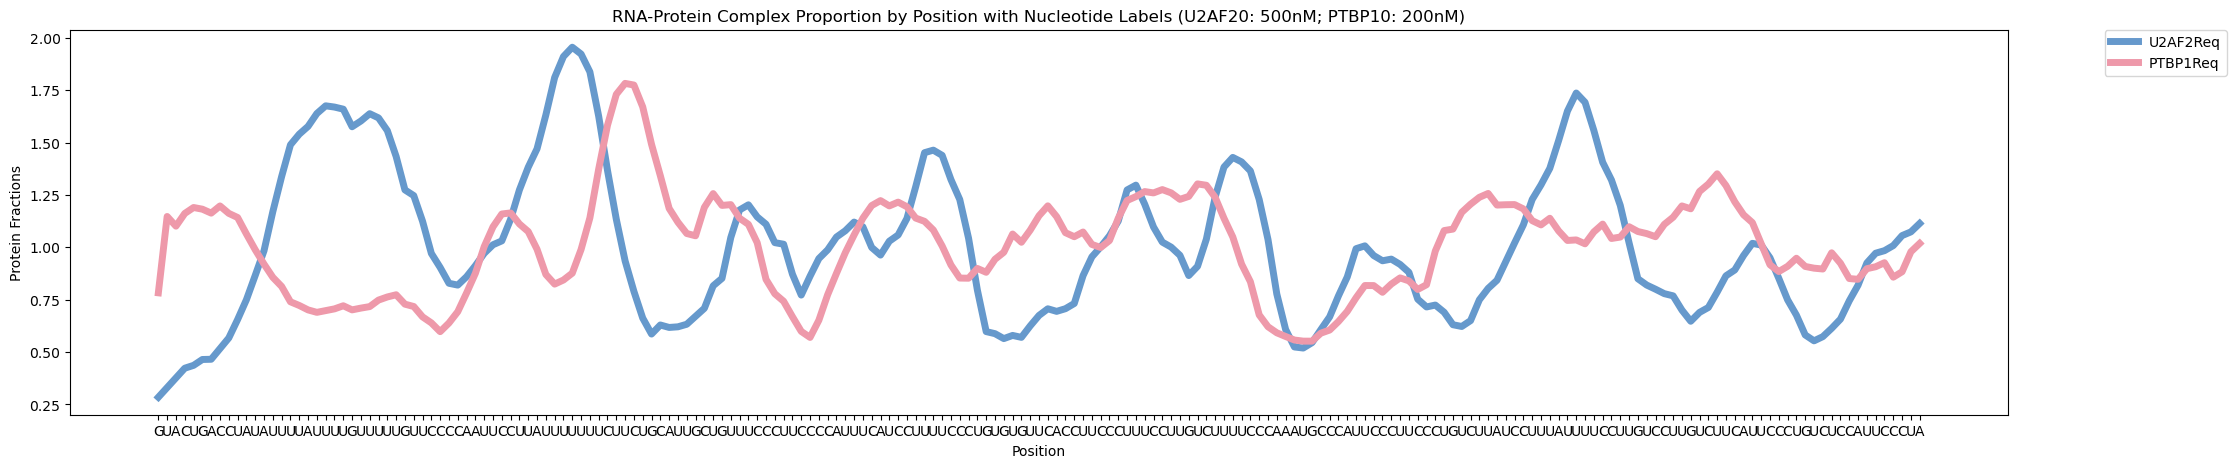

In [558]:
## Plot per position values for U2AF2 and PTBP1:

plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'U2AF2Req': (simulation_per_pos.U2AF2Req/(R0))/sum(simulation_per_pos.U2AF2Req/(R0))*100,
    # 'PTBP1Req': (simulation_per_pos.PTBP1Req/(R0))/sum(simulation_per_pos.PTBP1Req/(R0))*100,
    # 'U2AF2Req': (simulation_per_pos.U2AF2Req/(R0))/U2AF20*100,
    # 'PTBP1Req': (simulation_per_pos.PTBP1Req/(R0))/PTBP10*100,
    'PTBP1Req': (PTBP10*simulation_per_pos.PTBP1Req/integrate.trapezoid(simulation_per_pos.PTBP1Req,simulation_per_pos.pos))/ (PTBP10/len(query)),
    'U2AF2Req': (U2AF20*simulation_per_pos.U2AF2Req/integrate.trapezoid(simulation_per_pos.U2AF2Req,simulation_per_pos.pos))/ (U2AF20/len(query))
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['U2AF2Req', 'PTBP1Req'], var_name='variable', value_name='value')
plot_color = {'U2AF2Req': '#6699CC', 'PTBP1Req': '#EE99AA'}

plt.figure(figsize=(25, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable', palette = plot_color, lw = 5)

# plt.ylim(0.5, 2)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

 

plt.xlabel('Position')
plt.ylabel('Protein Fractions')
plt.title('RNA-Protein Complex Proportion by Position with Nucleotide Labels (U2AF20: ' + str(U2AF20) + 'nM; PTBP10: ' + str(PTBP10) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

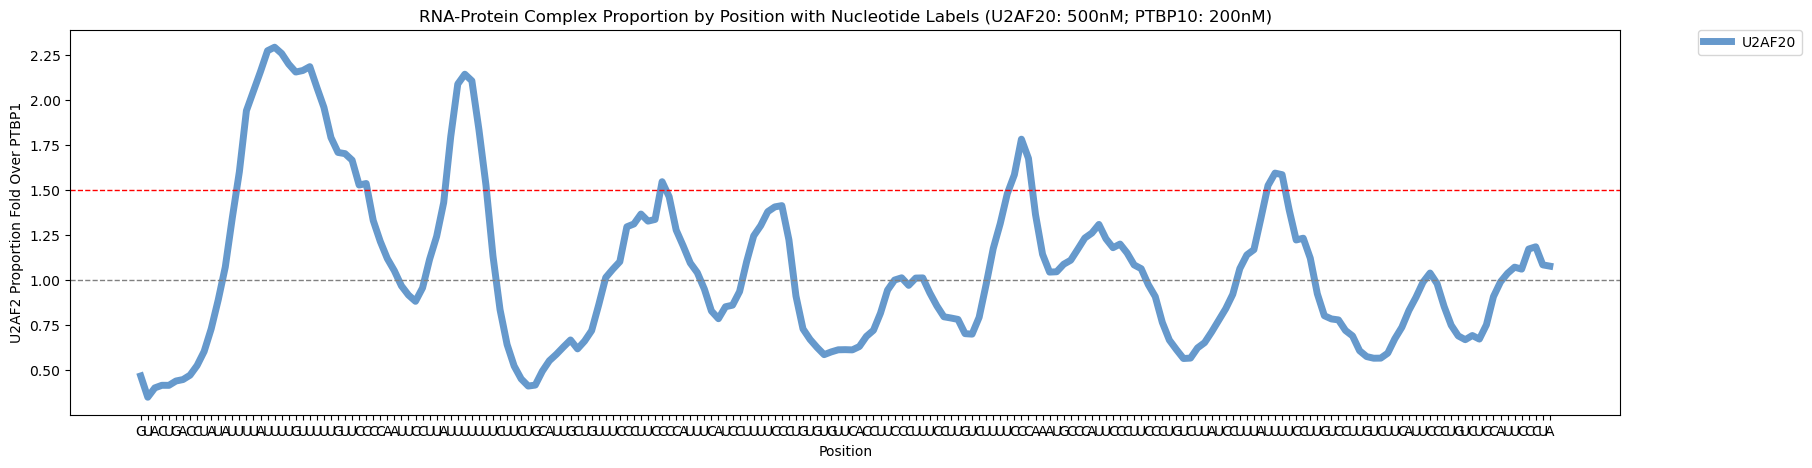

In [544]:
## Proportion comparison:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'PTBP1Req': (PTBP10*simulation_per_pos.PTBP1Req/integrate.trapezoid(simulation_per_pos.PTBP1Req,simulation_per_pos.pos))/ (PTBP10/len(query)),
    'U2AF2Req': (U2AF20*simulation_per_pos.U2AF2Req/integrate.trapezoid(simulation_per_pos.U2AF2Req,simulation_per_pos.pos))/ (U2AF20/len(query))
})

plot_data['U2AF20'] = plot_data.U2AF2Req / plot_data.PTBP1Req

plot_data = plot_data.melt(id_vars='pos', value_vars=['U2AF20'], var_name='variable', value_name='value')
plot_color = {'U2AF20': '#6699CC'}

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable', palette = plot_color, lw = 5)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1)

# plt.ylim(0, 3)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('U2AF2 Proportion Fold Over PTBP1')
plt.title('RNA-Protein Complex Proportion by Position with Nucleotide Labels (U2AF20: ' + str(U2AF20) + 'nM; PTBP10: ' + str(PTBP10) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

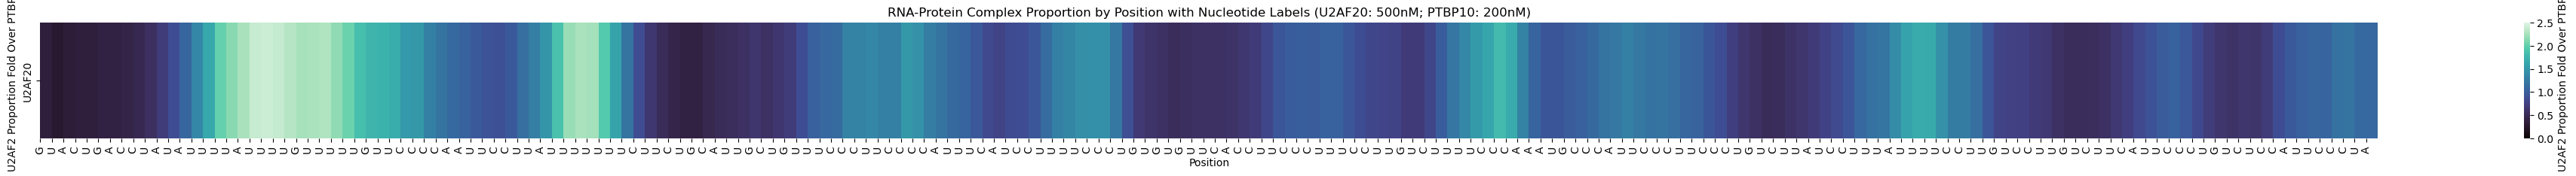

In [559]:
## Proportion in heatmap:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'PTBP1Req': (PTBP10*simulation_per_pos.PTBP1Req/integrate.trapezoid(simulation_per_pos.PTBP1Req,simulation_per_pos.pos))/ (PTBP10/len(query)),
    'U2AF2Req': (U2AF20*simulation_per_pos.U2AF2Req/integrate.trapezoid(simulation_per_pos.U2AF2Req,simulation_per_pos.pos))/ (U2AF20/len(query))
})

# plot_data = plot_data.melt(id_vars='pos', value_vars=['U2AF2Req'], var_name='variable', value_name='value')

plot_data['U2AF20'] = (plot_data.U2AF2Req / plot_data.PTBP1Req)
plot_data = plot_data.melt(id_vars='pos', value_vars=['U2AF20'], var_name='variable', value_name='value')

heatmap_data = plot_data.pivot(index='pos', columns='variable', values='value')

# Create the heatmap
plt.figure(figsize=(50, 2))
sns.heatmap(heatmap_data.T, cmap='mako', cbar_kws={'label': 'U2AF2 Proportion Fold Over PTBP1'}, vmin=0, vmax=2.5)

plt.xlabel('Position')
plt.ylabel('U2AF2 Proportion Fold Over PTBP1')
plt.title('RNA-Protein Complex Proportion by Position with Nucleotide Labels (U2AF20: ' + str(U2AF20) + 'nM; PTBP10: ' + str(PTBP10) + 'nM)')
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

# plt.show()
plt.savefig('/Users/soonyi/Desktop/U2AF2_PTBP1.pdf')

In [560]:
## Set up simulation for U2AF2 and HNRNPC:
################################################################################
N = 2
U2AF20 = 500
HNRNPC0 = 200

P0 = [U2AF20, HNRNPC0]
R0 = 10

In [561]:
## Run simulation for U2AF2 and HNRNPC:
################################################################################
U2AF2 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.U2AF2,
   })


HNRNPC = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.HNRNPC,
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'U2AF2Req': [None] * W,
   'HNRNPCReq': [None] * W
   })


## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  
  Kd_U2AF2 = U2AF2.loc[U2AF2.motif == window, 'Kd'].values[0]
  Kd_HNRNPC = HNRNPC.loc[HNRNPC.motif == window, 'Kd'].values[0]

  Kd = [Kd_U2AF2, Kd_HNRNPC]
  Req = allBind(N, eR0, P0, Kd)
  
  U2AF2Req = (U2AF20 * Req)/(Kd_U2AF2 + Req)
  HNRNPCReq = (HNRNPC0 * Req)/(Kd_HNRNPC + Req)
 
  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'U2AF2Req'] = U2AF2Req/appearance
  simulation.loc[simulation.motif == window, 'HNRNPCReq'] = HNRNPCReq/appearance

simulation = simulation.sort_values(by = ["win_num"])

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'U2AF2Req': np.zeros(L),
    'U2AF2/U2AF20': np.zeros(L),
    'HNRNPCReq': np.zeros(L),
    'HNRNPC/HNRNPC0': np.zeros(L)
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] = simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] + simulation.U2AF2Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HNRNPCReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HNRNPCReq'] + simulation.HNRNPCReq[idx]

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['U2AF2Req'] = simulation_per_pos['U2AF2Req'] / np.maximum(update_counts, 1)
simulation_per_pos['HNRNPCReq'] = simulation_per_pos['HNRNPCReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['U2AF2/R0'] = (simulation_per_pos['U2AF2Req'])/R0
simulation_per_pos['HNRNPC/R0'] = (simulation_per_pos['HNRNPCReq'])/R0


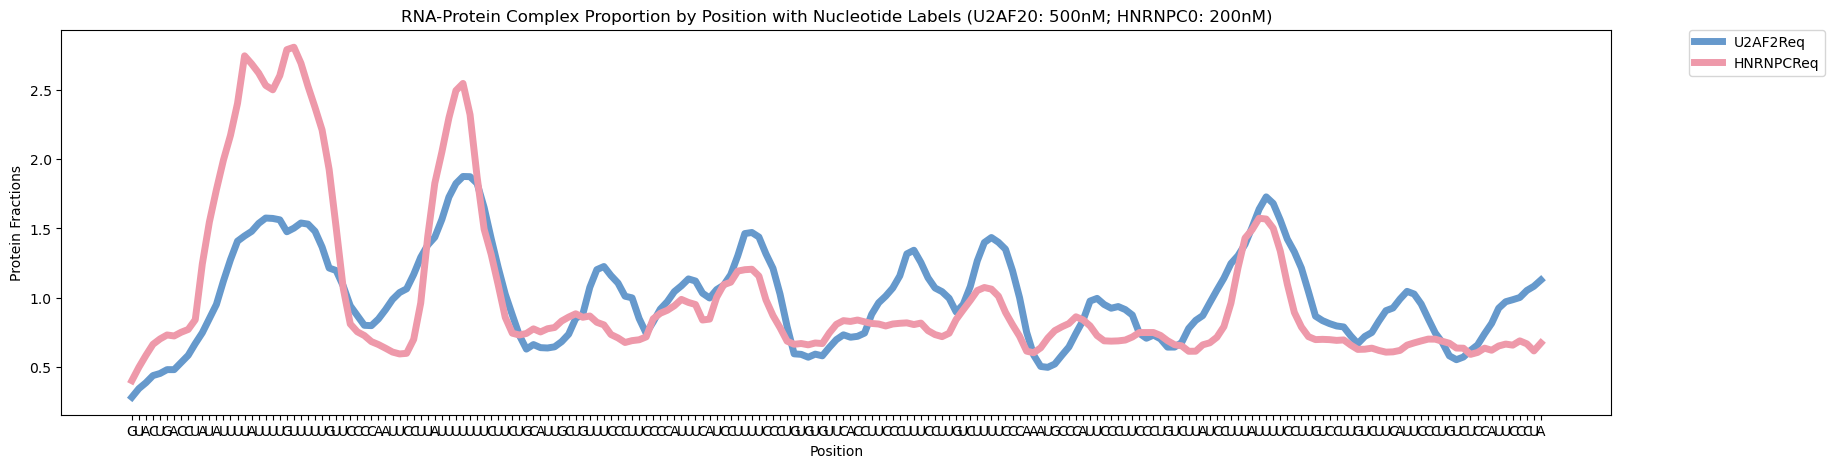

In [562]:
## Plot per position values for U2AF2 and HNRNPC:

plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'HNRNPCReq': (HNRNPC0*simulation_per_pos.HNRNPCReq/integrate.trapezoid(simulation_per_pos.HNRNPCReq,simulation_per_pos.pos))/ (HNRNPC0/len(query)),
    'U2AF2Req': (U2AF20*simulation_per_pos.U2AF2Req/integrate.trapezoid(simulation_per_pos.U2AF2Req,simulation_per_pos.pos))/ (U2AF20/len(query))
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['U2AF2Req', 'HNRNPCReq'], var_name='variable', value_name='value')
plot_color = {'U2AF2Req': '#6699CC', 'HNRNPCReq': '#EE99AA'}

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable', palette = plot_color, lw = 5)

# plt.ylim(0, 5)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

 

plt.xlabel('Position')
plt.ylabel('Protein Fractions')
plt.title('RNA-Protein Complex Proportion by Position with Nucleotide Labels (U2AF20: ' + str(U2AF20) + 'nM; HNRNPC0: ' + str(HNRNPC0) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

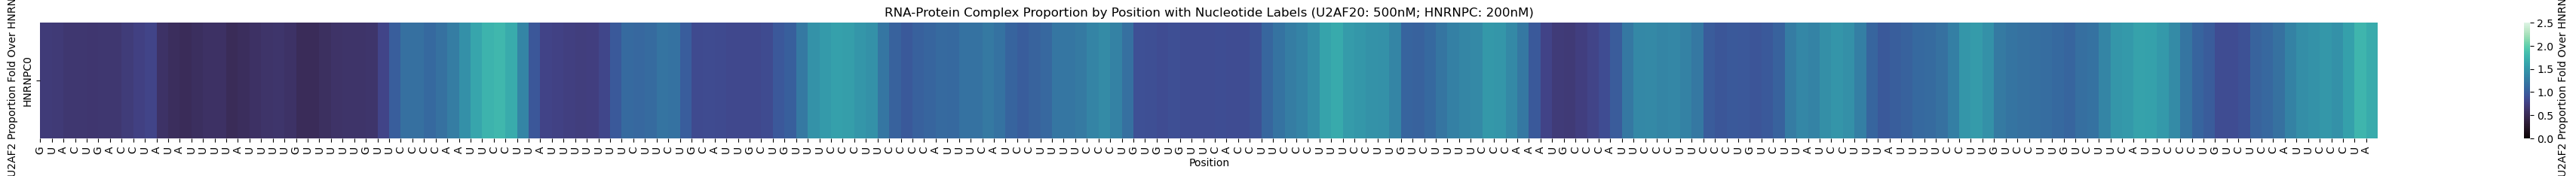

In [563]:
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'HNRNPCReq': (HNRNPC0*simulation_per_pos.HNRNPCReq/integrate.trapezoid(simulation_per_pos.HNRNPCReq,simulation_per_pos.pos))/ (HNRNPC0/len(query)),
    'U2AF2Req': (U2AF20*simulation_per_pos.U2AF2Req/integrate.trapezoid(simulation_per_pos.U2AF2Req,simulation_per_pos.pos))/ (U2AF20/len(query))
})

# plot_data = plot_data.melt(id_vars='pos', value_vars=['U2AF2Req'], var_name='variable', value_name='value')

plot_data['HNRNPC0'] = plot_data.U2AF2Req / plot_data.HNRNPCReq
plot_data = plot_data.melt(id_vars='pos', value_vars=['HNRNPC0'], var_name='variable', value_name='value')

heatmap_data = plot_data.pivot(index='pos', columns='variable', values='value')

# Create the heatmap
plt.figure(figsize=(50, 2))
sns.heatmap(heatmap_data.T, cmap='mako', cbar_kws={'label': 'U2AF2 Proportion Fold Over HNRNPC'}, vmin=0, vmax=2.5)

plt.xlabel('Position')
plt.ylabel('U2AF2 Proportion Fold Over HNRNPC')
plt.title('RNA-Protein Complex Proportion by Position with Nucleotide Labels (U2AF20: ' + str(U2AF20) + 'nM; HNRNPC: ' + str(PTBP10) + 'nM)')
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

# plt.show()
plt.savefig('/Users/soonyi/Desktop/U2AF2_HNRNPC.pdf')

In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 1
# HH0 = 100
HL0 = 100
# LH0 = 100
# LL0 = 100

# P0 = [HH0, HL0, LH0, LL0]
P0 = [HL0]
R0 = 10

# HH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['HH'],
#    })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

# LH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LH'],
#    })

# LL = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LL'],
#    })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
#    'HHReq': [None] * W,
   'HLReq': [None] * W,
#    'LHReq': [None] * W,
#    'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
#   Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HL['motif'] == window, 'Kd'].values[0]
#   Kd_LH = LH.loc[LH['motif'] == window, 'Kd'].values[0]
#   Kd_LL = LL.loc[LL['motif'] == window, 'Kd'].values[0]
  
#   Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
  Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
#   HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
#   LHReq = (LH0 * Req)/(Kd_LH + Req)
#   LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
#   simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
#   simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
#   simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    # 'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    # 'LHReq': np.zeros(L),
    # 'LLReq': np.zeros(L),
    # 'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    # 'LH/LH0': np.zeros(L),
    # 'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
# simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
# simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
# simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
# simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'HHReq': (simulation_per_pos.HHReq/R0)/sum(simulation_per_pos.HHReq/R0)*100,
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    # 'LHReq': (simulation_per_pos.LHReq/R0)/sum(simulation_per_pos.LHReq/R0)*100,
    # 'LLReq': (simulation_per_pos.LLReq/R0)/sum(simulation_per_pos.LLReq/R0)*100
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 2.5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0.8, 1.2)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction')
plt.title('Four RBPs Probability by Position with Nucleotide Labels (HL0: ' + str(HL0) + 'nM; R0: ' + str(R0) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 1
# HH0 = 100
HL0 = 100
# LH0 = 100
# LL0 = 100

# P0 = [HH0, HL0, LH0, LL0]
P0 = [HL0]
R0 = 25

# HH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['HH'],
#    })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

# LH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LH'],
#    })

# LL = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LL'],
#    })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
#    'HHReq': [None] * W,
   'HLReq': [None] * W,
#    'LHReq': [None] * W,
#    'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
#   Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HL['motif'] == window, 'Kd'].values[0]
#   Kd_LH = LH.loc[LH['motif'] == window, 'Kd'].values[0]
#   Kd_LL = LL.loc[LL['motif'] == window, 'Kd'].values[0]
  
#   Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
  Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
#   HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
#   LHReq = (LH0 * Req)/(Kd_LH + Req)
#   LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
#   simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
#   simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
#   simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    # 'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    # 'LHReq': np.zeros(L),
    # 'LLReq': np.zeros(L),
    # 'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    # 'LH/LH0': np.zeros(L),
    # 'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
# simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
# simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
# simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
# simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'HHReq': (simulation_per_pos.HHReq/R0)/sum(simulation_per_pos.HHReq/R0)*100,
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    # 'LHReq': (simulation_per_pos.LHReq/R0)/sum(simulation_per_pos.LHReq/R0)*100,
    # 'LLReq': (simulation_per_pos.LLReq/R0)/sum(simulation_per_pos.LLReq/R0)*100
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 2.5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0.8, 1.2)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction')
plt.title('Four RBPs Probability by Position with Nucleotide Labels (HL0: ' + str(HL0) + 'nM; R0: ' + str(R0) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 1
# HH0 = 100
HL0 = 100
# LH0 = 100
# LL0 = 100

# P0 = [HH0, HL0, LH0, LL0]
P0 = [HL0]
R0 = 50

# HH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['HH'],
#    })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

# LH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LH'],
#    })

# LL = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LL'],
#    })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
#    'HHReq': [None] * W,
   'HLReq': [None] * W,
#    'LHReq': [None] * W,
#    'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
#   Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HL['motif'] == window, 'Kd'].values[0]
#   Kd_LH = LH.loc[LH['motif'] == window, 'Kd'].values[0]
#   Kd_LL = LL.loc[LL['motif'] == window, 'Kd'].values[0]
  
#   Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
  Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
#   HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
#   LHReq = (LH0 * Req)/(Kd_LH + Req)
#   LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
#   simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
#   simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
#   simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    # 'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    # 'LHReq': np.zeros(L),
    # 'LLReq': np.zeros(L),
    # 'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    # 'LH/LH0': np.zeros(L),
    # 'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
# simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
# simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
# simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
# simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'HHReq': (simulation_per_pos.HHReq/R0)/sum(simulation_per_pos.HHReq/R0)*100,
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    # 'LHReq': (simulation_per_pos.LHReq/R0)/sum(simulation_per_pos.LHReq/R0)*100,
    # 'LLReq': (simulation_per_pos.LLReq/R0)/sum(simulation_per_pos.LLReq/R0)*100
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 2.5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0.8, 1.2)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction')
plt.title('Four RBPs Probability by Position with Nucleotide Labels (HL0: ' + str(HL0) + 'nM; R0: ' + str(R0) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 1
# HH0 = 100
HL0 = 100
# LH0 = 100
# LL0 = 100

# P0 = [HH0, HL0, LH0, LL0]
P0 = [HL0]
R0 = 100

# HH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['HH'],
#    })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

# LH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LH'],
#    })

# LL = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LL'],
#    })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
#    'HHReq': [None] * W,
   'HLReq': [None] * W,
#    'LHReq': [None] * W,
#    'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
#   Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HL['motif'] == window, 'Kd'].values[0]
#   Kd_LH = LH.loc[LH['motif'] == window, 'Kd'].values[0]
#   Kd_LL = LL.loc[LL['motif'] == window, 'Kd'].values[0]
  
#   Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
  Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
#   HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
#   LHReq = (LH0 * Req)/(Kd_LH + Req)
#   LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
#   simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
#   simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
#   simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    # 'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    # 'LHReq': np.zeros(L),
    # 'LLReq': np.zeros(L),
    # 'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    # 'LH/LH0': np.zeros(L),
    # 'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
# simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
# simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
# simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
# simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'HHReq': (simulation_per_pos.HHReq/R0)/sum(simulation_per_pos.HHReq/R0)*100,
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    # 'LHReq': (simulation_per_pos.LHReq/R0)/sum(simulation_per_pos.LHReq/R0)*100,
    # 'LLReq': (simulation_per_pos.LLReq/R0)/sum(simulation_per_pos.LLReq/R0)*100
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 2.5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0.8, 1.2)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction')
plt.title('Four RBPs Probability by Position with Nucleotide Labels (HL0: ' + str(HL0) + 'nM; R0: ' + str(R0) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 1
# HH0 = 100
HL0 = 100
# LH0 = 100
# LL0 = 100

# P0 = [HH0, HL0, LH0, LL0]
P0 = [HL0]
R0 = 250

# HH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['HH'],
#    })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

# LH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LH'],
#    })

# LL = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LL'],
#    })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
#    'HHReq': [None] * W,
   'HLReq': [None] * W,
#    'LHReq': [None] * W,
#    'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
#   Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HL['motif'] == window, 'Kd'].values[0]
#   Kd_LH = LH.loc[LH['motif'] == window, 'Kd'].values[0]
#   Kd_LL = LL.loc[LL['motif'] == window, 'Kd'].values[0]
  
#   Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
  Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
#   HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
#   LHReq = (LH0 * Req)/(Kd_LH + Req)
#   LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
#   simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
#   simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
#   simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    # 'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    # 'LHReq': np.zeros(L),
    # 'LLReq': np.zeros(L),
    # 'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    # 'LH/LH0': np.zeros(L),
    # 'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
# simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
# simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
# simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
# simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'HHReq': (simulation_per_pos.HHReq/R0)/sum(simulation_per_pos.HHReq/R0)*100,
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    # 'LHReq': (simulation_per_pos.LHReq/R0)/sum(simulation_per_pos.LHReq/R0)*100,
    # 'LLReq': (simulation_per_pos.LLReq/R0)/sum(simulation_per_pos.LLReq/R0)*100
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 2.5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0.8, 1.2)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction')
plt.title('Four RBPs Probability by Position with Nucleotide Labels (HL0: ' + str(HL0) + 'nM; R0: ' + str(R0) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 1
# HH0 = 100
HL0 = 100
# LH0 = 100
# LL0 = 100

# P0 = [HH0, HL0, LH0, LL0]
P0 = [HL0]
R0 = 500

# HH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['HH'],
#    })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

# LH = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LH'],
#    })

# LL = pd.DataFrame({
#    'motif': Model_Ka.Motif,
#    'Kd': 1/Model_Ka['LL'],
#    })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
#    'HHReq': [None] * W,
   'HLReq': [None] * W,
#    'LHReq': [None] * W,
#    'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
#   Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HL['motif'] == window, 'Kd'].values[0]
#   Kd_LH = LH.loc[LH['motif'] == window, 'Kd'].values[0]
#   Kd_LL = LL.loc[LL['motif'] == window, 'Kd'].values[0]
  
#   Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
  Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
#   HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
#   LHReq = (LH0 * Req)/(Kd_LH + Req)
#   LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
#   simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
#   simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
#   simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    # 'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    # 'LHReq': np.zeros(L),
    # 'LLReq': np.zeros(L),
    # 'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    # 'LH/LH0': np.zeros(L),
    # 'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    # simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
# simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
# simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
# simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
# simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
# simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    # 'HHReq': (simulation_per_pos.HHReq/R0)/sum(simulation_per_pos.HHReq/R0)*100,
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    # 'LHReq': (simulation_per_pos.LHReq/R0)/sum(simulation_per_pos.LHReq/R0)*100,
    # 'LLReq': (simulation_per_pos.LLReq/R0)/sum(simulation_per_pos.LLReq/R0)*100
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 2.5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0.8, 1.2)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction')
plt.title('Four RBPs Probability by Position with Nucleotide Labels (HL0: ' + str(HL0) + 'nM; R0: ' + str(R0) + 'nM)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 4
HH0 = 100
HL0 = 100
LH0 = 100
LL0 = 100

P0 = [HH0, HL0, LH0, LL0]
# P0 = [HL0]
R0 = 10

HH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HH'],
   })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

LH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LH'],
   })

LL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LL'],
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'HHReq': [None] * W,
   'HLReq': [None] * W,
   'LHReq': [None] * W,
   'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LH = LH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LL = LL.loc[HH['motif'] == window, 'Kd'].values[0]
  
  Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
#   Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
  HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
  LHReq = (LH0 * Req)/(Kd_LH + Req)
  LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
  simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
  simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    'LHReq': np.zeros(L),
    'LLReq': np.zeros(L),
    'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    'LH/LH0': np.zeros(L),
    'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0



## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'HHReq': (HL0*simulation_per_pos.HHReq/integrate.trapezoid(simulation_per_pos.HHReq,simulation_per_pos.pos))/ (HH0/len(query)),
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    'LHReq': (HL0*simulation_per_pos.LHReq/integrate.trapezoid(simulation_per_pos.LHReq,simulation_per_pos.pos))/ (LH0/len(query)),
    'LLReq': (HL0*simulation_per_pos.LLReq/integrate.trapezoid(simulation_per_pos.LLReq,simulation_per_pos.pos))/ (LL0/len(query)),
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HHReq', 'HLReq', 'LHReq', 'LLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0, 3)
# plt.yscale('log', base = 2)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Fraction of RBP Distributed to each')
plt.title('Four RBPs Normalized Protein Fraction Fold Over by Position with Nucleotide Labels (HH: ' + str(HH0) + ', HL: ' + str(HL0) + ', LH: ' + str(LH0) + ', LL: ' + str(LL0) + ', R0: ' + str(R0) + ')')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [ ]:
simulation_per_pos

In [ ]:
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'nt': simulation_per_pos.nt,
    'HHReq': (HL0*simulation_per_pos.HHReq/integrate.trapezoid(simulation_per_pos.HHReq,simulation_per_pos.pos))/ (HH0/len(query)),
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    'LHReq': (HL0*simulation_per_pos.LHReq/integrate.trapezoid(simulation_per_pos.LHReq,simulation_per_pos.pos))/ (LH0/len(query)),
    'LLReq': (HL0*simulation_per_pos.LLReq/integrate.trapezoid(simulation_per_pos.LLReq,simulation_per_pos.pos))/ (LL0/len(query)),
})

plot_data.to_csv('/Users/soonyi/plot_data.csv')

In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 4
HH0 = 100
HL0 = 100
LH0 = 100
LL0 = 100

P0 = [HH0, HL0, LH0, LL0]
# P0 = [HL0]
R0 = 25

HH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HH'],
   })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

LH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LH'],
   })

LL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LL'],
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'HHReq': [None] * W,
   'HLReq': [None] * W,
   'LHReq': [None] * W,
   'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LH = LH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LL = LL.loc[HH['motif'] == window, 'Kd'].values[0]
  
  Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
#   Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
  HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
  LHReq = (LH0 * Req)/(Kd_LH + Req)
  LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
  simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
  simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    'LHReq': np.zeros(L),
    'LLReq': np.zeros(L),
    'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    'LH/LH0': np.zeros(L),
    'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'HHReq': (HL0*simulation_per_pos.HHReq/integrate.trapezoid(simulation_per_pos.HHReq,simulation_per_pos.pos))/ (HH0/len(query)),
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    'LHReq': (HL0*simulation_per_pos.LHReq/integrate.trapezoid(simulation_per_pos.LHReq,simulation_per_pos.pos))/ (LH0/len(query)),
    'LLReq': (HL0*simulation_per_pos.LLReq/integrate.trapezoid(simulation_per_pos.LLReq,simulation_per_pos.pos))/ (LL0/len(query)),
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HHReq', 'HLReq', 'LHReq', 'LLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0, 3)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction Fold Change')
plt.title('Four RBPs Normalized Protein Fraction Fold Over by Position with Nucleotide Labels (HH: ' + str(HH0) + ', HL: ' + str(HL0) + ', LH: ' + str(LH0) + ', LL: ' + str(LL0) + ', R0: ' + str(R0) + ')')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()



In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 4
HH0 = 100
HL0 = 100
LH0 = 100
LL0 = 100

P0 = [HH0, HL0, LH0, LL0]
# P0 = [HL0]
R0 = 50

HH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HH'],
   })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

LH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LH'],
   })

LL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LL'],
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'HHReq': [None] * W,
   'HLReq': [None] * W,
   'LHReq': [None] * W,
   'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LH = LH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LL = LL.loc[HH['motif'] == window, 'Kd'].values[0]
  
  Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
#   Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
  HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
  LHReq = (LH0 * Req)/(Kd_LH + Req)
  LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
  simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
  simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    'LHReq': np.zeros(L),
    'LLReq': np.zeros(L),
    'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    'LH/LH0': np.zeros(L),
    'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'HHReq': (HL0*simulation_per_pos.HHReq/integrate.trapezoid(simulation_per_pos.HHReq,simulation_per_pos.pos))/ (HH0/len(query)),
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    'LHReq': (HL0*simulation_per_pos.LHReq/integrate.trapezoid(simulation_per_pos.LHReq,simulation_per_pos.pos))/ (LH0/len(query)),
    'LLReq': (HL0*simulation_per_pos.LLReq/integrate.trapezoid(simulation_per_pos.LLReq,simulation_per_pos.pos))/ (LL0/len(query)),
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HHReq', 'HLReq', 'LHReq', 'LLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0, 3)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction Fold Change')
plt.title('Four RBPs Normalized Protein Fraction Fold Over by Position with Nucleotide Labels (HH: ' + str(HH0) + ', HL: ' + str(HL0) + ', LH: ' + str(LH0) + ', LL: ' + str(LL0) + ', R0: ' + str(R0) + ')')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()



In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 4
HH0 = 100
HL0 = 100
LH0 = 100
LL0 = 100

P0 = [HH0, HL0, LH0, LL0]
# P0 = [HL0]
R0 = 100

HH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HH'],
   })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

LH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LH'],
   })

LL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LL'],
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'HHReq': [None] * W,
   'HLReq': [None] * W,
   'LHReq': [None] * W,
   'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LH = LH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LL = LL.loc[HH['motif'] == window, 'Kd'].values[0]
  
  Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
#   Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
  HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
  LHReq = (LH0 * Req)/(Kd_LH + Req)
  LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
  simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
  simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    'LHReq': np.zeros(L),
    'LLReq': np.zeros(L),
    'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    'LH/LH0': np.zeros(L),
    'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'HHReq': (HL0*simulation_per_pos.HHReq/integrate.trapezoid(simulation_per_pos.HHReq,simulation_per_pos.pos))/ (HH0/len(query)),
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    'LHReq': (HL0*simulation_per_pos.LHReq/integrate.trapezoid(simulation_per_pos.LHReq,simulation_per_pos.pos))/ (LH0/len(query)),
    'LLReq': (HL0*simulation_per_pos.LLReq/integrate.trapezoid(simulation_per_pos.LLReq,simulation_per_pos.pos))/ (LL0/len(query)),
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HHReq', 'HLReq', 'LHReq', 'LLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0, 3)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction Fold Change')
plt.title('Four RBPs Normalized Protein Fraction Fold Over by Position with Nucleotide Labels (HH: ' + str(HH0) + ', HL: ' + str(HL0) + ', LH: ' + str(LH0) + ', LL: ' + str(LL0) + ', R0: ' + str(R0) + ')')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()



In [ ]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 100
Ka_L = 10

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=1)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=1)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=1)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=1)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 4
HH0 = 100
HL0 = 100
LH0 = 100
LL0 = 100

P0 = [HH0, HL0, LH0, LL0]
# P0 = [HL0]
R0 = 250

HH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HH'],
   })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

LH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LH'],
   })

LL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LL'],
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'HHReq': [None] * W,
   'HLReq': [None] * W,
   'LHReq': [None] * W,
   'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LH = LH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LL = LL.loc[HH['motif'] == window, 'Kd'].values[0]
  
  Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
#   Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
  HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
  LHReq = (LH0 * Req)/(Kd_LH + Req)
  LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
  simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
  simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    'LHReq': np.zeros(L),
    'LLReq': np.zeros(L),
    'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    'LH/LH0': np.zeros(L),
    'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'HHReq': (HL0*simulation_per_pos.HHReq/integrate.trapezoid(simulation_per_pos.HHReq,simulation_per_pos.pos))/ (HH0/len(query)),
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    'LHReq': (HL0*simulation_per_pos.LHReq/integrate.trapezoid(simulation_per_pos.LHReq,simulation_per_pos.pos))/ (LH0/len(query)),
    'LLReq': (HL0*simulation_per_pos.LLReq/integrate.trapezoid(simulation_per_pos.LLReq,simulation_per_pos.pos))/ (LL0/len(query)),
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HHReq', 'HLReq', 'LHReq', 'LLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

plt.ylim(0, 3)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction Fold Change')
plt.title('Four RBPs Normalized Protein Fraction Fold Over by Position with Nucleotide Labels (HH: ' + str(HH0) + ', HL: ' + str(HL0) + ', LH: ' + str(LH0) + ', LL: ' + str(LL0) + ', R0: ' + str(R0) + ')')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


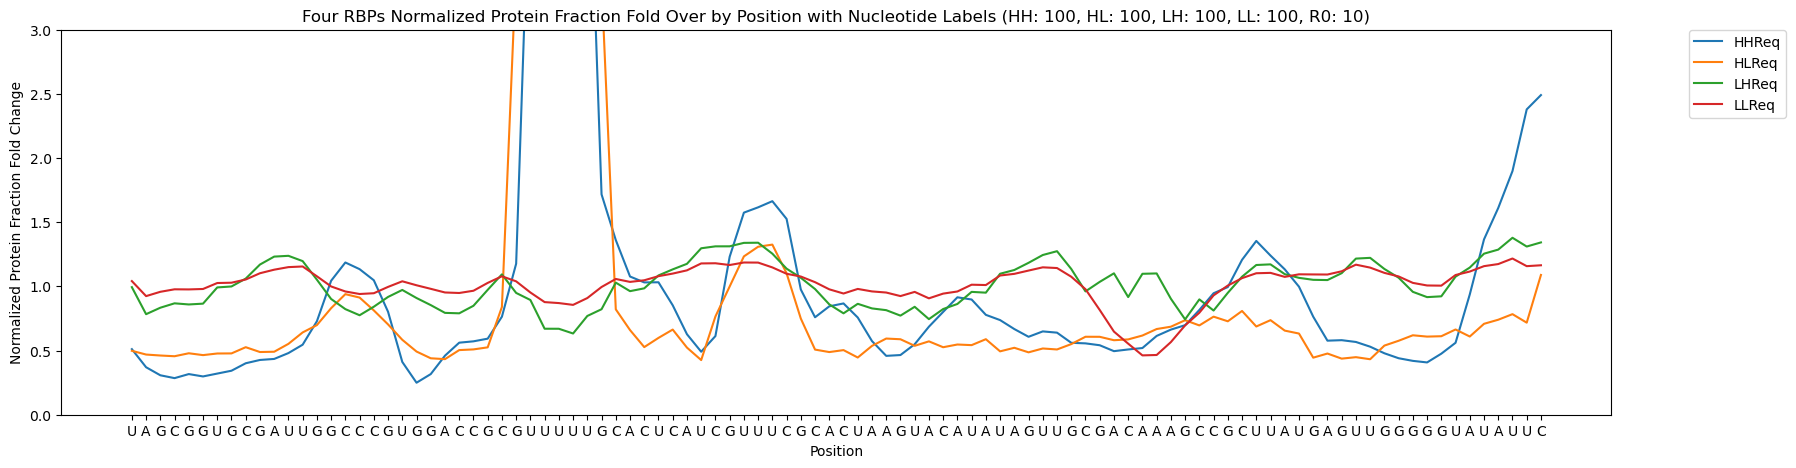

In [514]:
## Figure 4

################################################################################
## RNA-RBP Modeling 
## Written by Soon Yi
## Created: 2023-12-11
## Last Edited: 2023-12-12
################################################################################


## Load libraries
################################################################################
import pandas as pd
import numpy as np
import random
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/Model_RBP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq
################################################################################

## Set up query RNA:
################################################################################
# K:              K-mer
# query:          RNA sequence to test.
# L:              length of the query sequence.
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.
K = 5
L = 100

query = generateRNA(L=L, 
                    A=0.2,
                    G=0.2,
                    C=0.2,
                    U=0.4)

query = 'UAGCGGUGCGAUUGGCCCGUGGACCGCGUUUUUGCACUCAUCGUUUCGCACUAAGUACAUAUAGUUGCGACAAAGCCGCUUAUGAGUUGGGGGUAUAUUC'

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))
################################################################################

## Set up model RBPs:
################################################################################
Ka_H = 1/100
Ka_L = 1/1000

# Read in the model RBPs
ModelHH = pd.read_csv(baseDir + 'Model_HH.csv').sort_values(by='Motif')
ModelHL = pd.read_csv(baseDir + 'Model_HL.csv').sort_values(by='Motif')
ModelLH = pd.read_csv(baseDir + 'Model_LH.csv').sort_values(by='Motif')
ModelLL = pd.read_csv(baseDir + 'Model_LL.csv').sort_values(by='Motif')

# Combine the models into a single DataFrame
Model_Ka = pd.DataFrame({
    'Motif': ModelHH['Motif'],
    'HH': ModelHH['HH'],
    'HL': ModelHL['HL'],
    'LH': ModelLH['LH'],
    'LL': ModelLL['LL']
})

# Apply feature scaling
Model_Ka['HH'] = featureScale(Model_Ka['HH'], MAX=Ka_H, MIN=0.000001)
Model_Ka['HL'] = featureScale(Model_Ka['HL'], MAX=Ka_H, MIN=0.000001)
Model_Ka['LH'] = featureScale(Model_Ka['LH'], MAX=Ka_L, MIN=0.000001)
Model_Ka['LL'] = featureScale(Model_Ka['LL'], MAX=Ka_L, MIN=0.000001)
################################################################################

## Set up simulation for four RBPs:
################################################################################
N = 4
HH0 = 100
HL0 = 100
LH0 = 100
LL0 = 100

P0 = [HH0, HL0, LH0, LL0]
# P0 = [HL0]
R0 = 10

HH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HH'],
   })

HL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['HL'],
   })

LH = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LH'],
   })

LL = pd.DataFrame({
   'motif': Model_Ka.Motif,
   'Kd': 1/Model_Ka['LL'],
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'HHReq': [None] * W,
   'HLReq': [None] * W,
   'LHReq': [None] * W,
   'LLReq': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_HH = HH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_HL = HL.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LH = LH.loc[HH['motif'] == window, 'Kd'].values[0]
  Kd_LL = LL.loc[HH['motif'] == window, 'Kd'].values[0]
  
  Kd = [Kd_HH, Kd_HL, Kd_LH, Kd_LL]
#   Kd = [Kd_HL]
  Req = allBind(N, eR0, P0, Kd)
  
  HHReq = (HH0 * Req)/(Kd_HH + Req)
  HLReq = (HL0 * Req)/(Kd_HL + Req)
  LHReq = (LH0 * Req)/(Kd_LH + Req)
  LLReq = (LL0 * Req)/(Kd_LL + Req)

  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'HHReq'] = HHReq/appearance
  simulation.loc[simulation.motif == window, 'HLReq'] = HLReq/appearance
  simulation.loc[simulation.motif == window, 'LHReq'] = LHReq/appearance
  simulation.loc[simulation.motif == window, 'LLReq'] = LLReq/appearance

simulation = simulation.sort_values(by = ["win_num"])


simulation = simulation[simulation.columns[2:]].map(lambda x: x.real)

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'HHReq': np.zeros(L),
    'HLReq': np.zeros(L),
    'LHReq': np.zeros(L),
    'LLReq': np.zeros(L),
    'HH/HH0': np.zeros(L),
    'HL/HL0': np.zeros(L),
    'LH/LH0': np.zeros(L),
    'LL/LL0': np.zeros(L),
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HHReq'] + simulation.HHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'HLReq'] + simulation.HLReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LHReq'] + simulation.LHReq[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] = simulation_per_pos.loc[idx:idx+K-1, 'LLReq'] + simulation.LLReq[idx]
    

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['HHReq'] = simulation_per_pos['HHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['HLReq'] = simulation_per_pos['HLReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LHReq'] = simulation_per_pos['LHReq'] / np.maximum(update_counts, 1)
simulation_per_pos['LLReq'] = simulation_per_pos['LLReq'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['HH/R0'] = (simulation_per_pos['HHReq'])/R0
simulation_per_pos['HL/R0'] = (simulation_per_pos['HLReq'])/R0
simulation_per_pos['LH/R0'] = (simulation_per_pos['LHReq'])/R0
simulation_per_pos['LL/R0'] = (simulation_per_pos['LLReq'])/R0

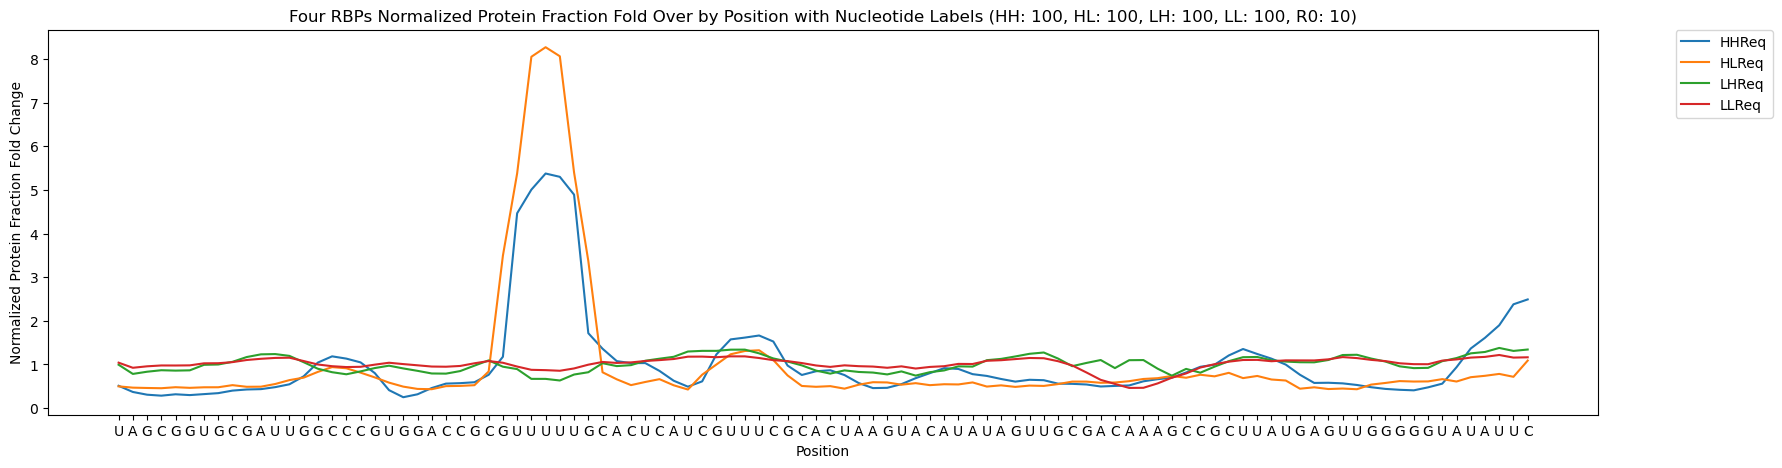

In [515]:
## Make dataframe for plotting:
################################################################################
plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'HHReq': (HL0*simulation_per_pos.HHReq/integrate.trapezoid(simulation_per_pos.HHReq,simulation_per_pos.pos))/ (HH0/len(query)),
    'HLReq': (HL0*simulation_per_pos.HLReq/integrate.trapezoid(simulation_per_pos.HLReq,simulation_per_pos.pos))/ (HL0/len(query)),
    'LHReq': (HL0*simulation_per_pos.LHReq/integrate.trapezoid(simulation_per_pos.LHReq,simulation_per_pos.pos))/ (LH0/len(query)),
    'LLReq': (HL0*simulation_per_pos.LLReq/integrate.trapezoid(simulation_per_pos.LLReq,simulation_per_pos.pos))/ (LL0/len(query)),
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['HHReq', 'HLReq', 'LHReq', 'LLReq'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable')

# plt.ylim(0, 3)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('Normalized Protein Fraction Fold Change')
plt.title('Four RBPs Normalized Protein Fraction Fold Over by Position with Nucleotide Labels (HH: ' + str(HH0) + ', HL: ' + str(HL0) + ', LH: ' + str(LH0) + ', LL: ' + str(LL0) + ', R0: ' + str(R0) + ')')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
